In [8]:
import os
import asyncio
from dotenv import load_dotenv
import openai
import aiohttp
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from typing import List, Dict


In [9]:
load_dotenv(override=True)
client = AsyncOpenAI(api_key=os.getenv("OPENAI_API_KEY"))

HEADERS = {"User-Agent": "Mozilla/5.0"}
BING_NEWS_URL = "https://www.bing.com/news/search?q={query}"


In [ ]:

#        BING SCRAPER SETUP      

# Fetch HTML content of a given URL using aiohttp
async def fetch_html(session, url):
    async with session.get(url, headers=HEADERS) as response:
        return await response.text()

# Scrape Bing News for article titles, snippets, and links
async def scrape_bing_news(session, keyword: str, max_results: int = 10):
    query = keyword.replace(" ", "+")
    url = BING_NEWS_URL.format(query=query)
    html = await fetch_html(session, url)
    soup = BeautifulSoup(html, "html.parser")

    # Parse articles using updated Bing News selectors
    cards = soup.find_all("a", class_="title")        # Headline links
    snippets = soup.find_all("div", class_="snippet") # Short description below title

    results = []
    for i in range(min(max_results, len(cards))):
        title_tag = cards[i]
        snippet_tag = snippets[i] if i < len(snippets) else None

        results.append({
            "title": title_tag.get_text(strip=True),
            "snippet": snippet_tag.get_text(strip=True) if snippet_tag else "No Snippet",
            "link": title_tag.get("href")
        })

    return results


#        TEXT SUMMARIZATION      


# Summarize all articles using OpenAI GPT-4
async def summarize_with_openai(articles: List[Dict]) -> str:
    # Create a single text block with all article titles and snippets
    text_block = "\n\n".join([f"Title: {a['title']}\nSnippet: {a['snippet']}" for a in articles])
    
    # Prepare messages for OpenAI chat completion
    messages = [
        {"role": "system", "content": "Summarize the following news articles."},
        {"role": "user", "content": text_block}
    ]
    
    # Call OpenAI API
    response = await client.chat.completions.create(
        model="gpt-4",
        messages=messages
    )
    
    # Extract and return the summary
    return response.choices[0].message.content


#         SENTIMENT ANALYSIS     


# Get sentiment score of an article title using GPT-3.5
# Returns: +1 = Positive, 0 = Neutral, -1 = Negative
async def get_sentiment_score(title: str) -> int:
    try:
        # Prepare prompt for sentiment classification
        response = await client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "system", "content": "Classify sentiment of a news headline as positive, negative, or neutral. Reply only with one word."},
                {"role": "user", "content": title}
            ]
        )
        
        # Extract response and convert to lowercase
        sentiment = response.choices[0].message.content.lower()
        
        # Convert sentiment word to score
        if "positive" in sentiment:
            return 1
        elif "negative" in sentiment:
            return -1
        else:
            return 0
    except Exception as e:
        print(f"Error for '{title}': {e}")
        return 0


#        DATA VISUALIZATION     

# Visualize sentiment scores of articles using a bar graph
async def visualize_sentiment(articles: List[Dict], keyword: str):
    print("🔍 Getting sentiment for article titles...")
    
    # Get sentiment scores for all article titles
    sentiments = await asyncio.gather(*(get_sentiment_score(article['title']) for article in articles))
    
    # Labels are just "1", "2", ..., "N" for N articles
    labels = [f"{i+1}" for i in range(len(articles))]
    
    # Create bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(
        labels, 
        sentiments, 
        color=['green' if s == 1 else 'red' if s == -1 else 'gray' for s in sentiments]
    )
    plt.xlabel('Article Number')
    plt.ylabel('Sentiment Score')
    plt.title(f'Sentiment of Article Titles for "{keyword}"')
    plt.ylim(-1.5, 1.5)
    plt.axhline(0, color='black', linestyle='--')  # horizontal reference line at 0
    plt.show()






In [ ]:
#      MAIN AGENT INTEGRATION    

# An agent class that handles the entire scrape, analyze, and visualize pipeline
class DataScraperAgent:
    async def scrape_and_visualize(self, keyword: str) -> str:
        async with aiohttp.ClientSession() as session:
            # Step 1: Scrape Bing News articles
            articles = await scrape_bing_news(session, keyword)
            if not articles:
                return "No articles found."

            # Step 2: Summarize the scraped articles
            summary = await summarize_with_openai(articles)

            # Step 3: Visualize sentiment of the article titles
            await visualize_sentiment(articles, keyword)

            # Step 4: Return the summary as string
            return f"### Summary of Articles for '{keyword}':\n\n{summary}"
            return f"### ✅ Summary of Articles for '{keyword}':\n\n{summary}"


🔎 Scraping news for: electric vehicles
🧠 Summarizing 10 articles...
📊 Visualizing sentiment...
🔍 Getting sentiment for article titles...


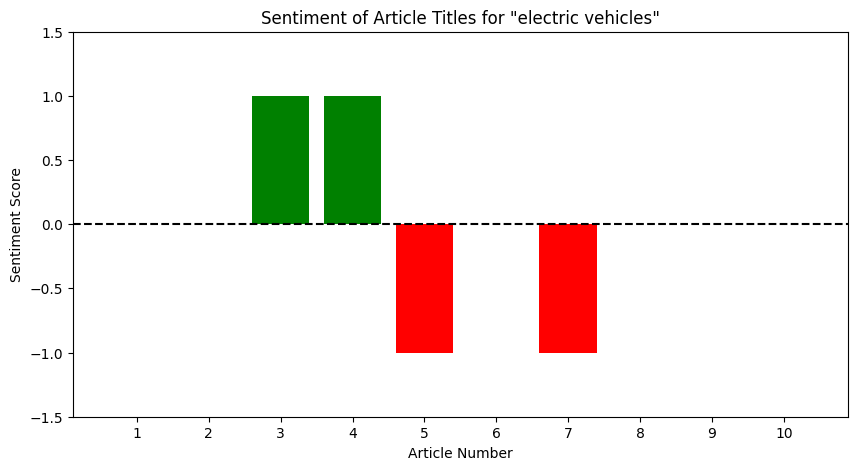

### ✅ Summary of Articles for 'electric vehicles':

1. The Indian government body Niti Aayog has started a study comparing lifecycle emissions of electric, hybrid, and conventional vehicles to decide its support for electric vehicles.

2. Honda has teased its first large-capacity electric motorcycle, EV Fun, scheduled for global debut on September 2.

3. Rare minerals in Peru may help boost India's IT sector and its shift towards electric vehicles.

4. Odysse Electric reports a rise in sales by 84% in July 2025 due to the successful debut of its new models, the HyFy and Racer Neo.

5. BEST, a transportation service in India, has grounded 100 electric vehicles due to expired fitness certificates and insurance.

6. ZF has started production of its Electric Park Brake system in India to improve vehicle safety.

7. Ola Electric's sales dipped by nearly half in the first seven months of the present year, even as its competitors forged ahead.

8. JSW Motors has collaborated with KPIT Tech to

In [15]:
agent = DataScraperAgent()
async def run_agent():
    keyword = "electric vehicles"
    result = await agent.scrape_and_visualize(keyword)
    print(result)

await run_agent()
